In [1]:
## !pip install -q transformers

In [2]:
## !pip install -q datasets jiwer

In [3]:
import torch

print("CUDA available:", torch.cuda.is_available())
print("CUDA version:", torch.version.cuda)

CUDA available: True
CUDA version: 11.8


In [4]:
import pandas as pd
import os

# Read the Excel file
df = pd.read_excel('tabelle_handwritting.xlsx', header=None)

# Rename columns
df.rename(columns={0: "file_name", 1: "text"}, inplace=True)

# Display the first few rows
df.head()


,file_name,text
0,0_1.jpg,Markus
1,0_11.jpg,15.04.2024
2,0_2.jpg,3366806
3,0_3.jpg,luedtke@gmx.de
4,0_4.jpg,Lüdtke


In [5]:
import torch
from torch.utils.data import Dataset
from PIL import Image

In [6]:
from sklearn.model_selection import train_test_split

# Split the data into training and testing sets (80% train, 20% test)
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

# Further split the training set into training and validation sets (70% train, 30% validation)
train_df, val_df = train_test_split(train_df, test_size=0.3, random_state=42)

# Reset the indices
train_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)
val_df.reset_index(drop=True, inplace=True)


In [7]:
class Dataset:
    def __init__(self, root_dir, df, processor, max_target_length=128):
        self.root_dir = root_dir
        self.df = df
        self.processor = processor
        self.max_target_length = max_target_length

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # get file name + text 
        file_name = self.df['file_name'][idx]
        text = str(self.df['text'][idx])  # Convert text to string explicitly
        
        # Prepare image (i.e. resize + normalize)
        image_path = os.path.join(self.root_dir, file_name)  # Create full file path
        image = Image.open(image_path).convert("RGB")
        pixel_values = self.processor(image, return_tensors="pt").pixel_values
        
        # Add labels (input_ids) by encoding the text
        labels = self.processor.tokenizer(text, 
                                           padding="max_length", 
                                           max_length=self.max_target_length).input_ids
        
        # Important: make sure that PAD tokens are ignored by the loss function
        labels = [label if label != self.processor.tokenizer.pad_token_id else -100 for label in labels]

        encoding = {"pixel_values": pixel_values.squeeze(), "labels": torch.tensor(labels)}
        return encoding

In [8]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
train_dataset = Dataset(root_dir='dataset/dataset_training/handwriting_dataset/dataset/',
                           df=train_df,
                           processor=processor)
eval_dataset = Dataset(root_dir='dataset/dataset_training/handwriting_dataset/dataset/',
                           df=val_df,
                           processor=processor)

test_dataset = Dataset(root_dir='dataset/dataset_training/handwriting_dataset/dataset/',
                           df=test_df,
                           processor=processor)

/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration. Please open a PR/issue to update `preprocessor_config.json` to use `image_processor_type` instead of `feature_extractor_type`. This warning will be removed in v4.40.


In [9]:
print("Number of training examples:", len(train_dataset))
print("Number of validation examples:", len(eval_dataset))
print("Number of test examples:", len(test_dataset))

Number of training examples: 364
Number of validation examples: 156
Number of test examples: 131


In [10]:
encoding = train_dataset[0]
for k,v in encoding.items():
  print(k, v.shape)

pixel_values torch.Size([3, 384, 384])
labels torch.Size([128])


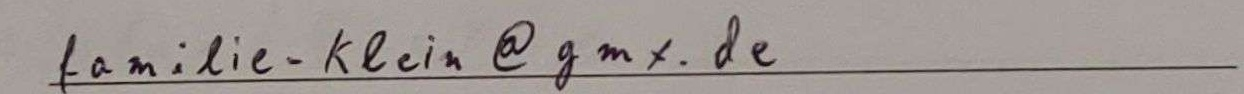

In [11]:
image = Image.open(os.path.join(train_dataset.root_dir , train_df['file_name'][0])).convert("RGB")
image

In [12]:
labels = encoding['labels']
labels[labels == -100] = processor.tokenizer.pad_token_id
label_str = processor.decode(labels, skip_special_tokens=True)
print(label_str)

familie-klein@gmx.de


In [13]:
from transformers import VisionEncoderDecoderModel

model = VisionEncoderDecoderModel.from_pretrained('microsoft/trocr-base-handwritten')

/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of VisionEncoderDecoderModel were not initialized from the model checkpoint at microsoft/trocr-base-handwritten and are newly initialized: ['encoder.pooler.dense.bias', 'encoder.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# set special tokens used for creating the decoder_input_ids from the labels
model.config.decoder_start_token_id = processor.tokenizer.cls_token_id
model.config.pad_token_id = processor.tokenizer.pad_token_id
# make sure vocab size is set correctly
model.config.vocab_size = model.config.decoder.vocab_size

# set beam search parameters
model.config.eos_token_id = processor.tokenizer.sep_token_id
model.config.max_length = 64
model.config.early_stopping = True
model.config.no_repeat_ngram_size = 3
model.config.length_penalty = 2.0
model.config.num_beams = 4

In [15]:
from transformers import Seq2SeqTrainer, Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    predict_with_generate=True,
    num_train_epochs=50,
    evaluation_strategy="steps",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    fp16=False, 
    output_dir="./",
    logging_steps=2,
    save_steps=1000,
    eval_steps=200,
)

In [16]:
from datasets import load_metric

cer_metric = load_metric("cer",trust_remote_code=True)

/tmp/ipykernel_1477/3245227114.py:3: FutureWarning: load_metric is deprecated and will be removed in the next major version of datasets. Use 'evaluate.load' instead, from the new library 🤗 Evaluate: https://huggingface.co/docs/evaluate
  cer_metric = load_metric("cer",trust_remote_code=True)


In [17]:
def compute_metrics(pred):
    labels_ids = pred.label_ids
    pred_ids = pred.predictions

    pred_str = processor.batch_decode(pred_ids, skip_special_tokens=True)
    labels_ids[labels_ids == -100] = processor.tokenizer.pad_token_id
    label_str = processor.batch_decode(labels_ids, skip_special_tokens=True)

    cer = cer_metric.compute(predictions=pred_str, references=label_str)

    return {"cer": cer}

In [18]:
from transformers import default_data_collator

# instantiate trainer
trainer = Seq2SeqTrainer(
    model=model,
    tokenizer=processor.image_processor,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    data_collator=default_data_collator,
)
trainer.train()

Step,Training Loss,Validation Loss,Cer
200,0.242000,0.985367,0.243478
400,0.151800,1.064125,0.274396
600,0.078400,1.070942,0.212560
800,0.208400,1.385625,0.291787
1000,0.008700,1.061703,0.205797
1200,0.000200,1.071002,0.205797
1400,0.000000,1.162190,0.214493
1600,0.000000,1.085561,0.191304
1800,0.000000,1.077935,0.194203
2000,0.000000,1.074480,0.194203


/home/sonotokay/miniconda3/envs/everything/lib/python3.10/site-packages/transformers/generation/utils.py:1256: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
Some non-default generation parameters are set in the model config. These should go into a GenerationConfig file (https://huggingface.co/docs/transformers/generation_strategies#save-a-custom-decoding-strategy-with-your-model) instead. This warning will be raised to an exception in v4.41.
Non-default generation parameters: {'max_length': 64, 'early_stopping': True, 'num_beams': 4, 'length_penalty': 2.0, 'no_repeat_ngram_size': 3}
Some non-default generation parameters are set in the model config. These should go in

TrainOutput(global_step=2300, training_loss=0.1249131471464623, metrics={'train_runtime': 1866.202, 'train_samples_per_second': 9.752, 'train_steps_per_second': 1.232, 'total_flos': 1.3618790476126618e+19, 'train_loss': 0.1249131471464623, 'epoch': 50.0})

In [19]:
# Evaluate on the test dataset
results = trainer.evaluate(test_dataset)
print(results)


{'eval_loss': 1.2473732233047485, 'eval_cer': 0.1844946025515211, 'eval_runtime': 20.4496, 'eval_samples_per_second': 6.406, 'eval_steps_per_second': 0.831, 'epoch': 50.0}


In [ ]:
generated_ids = model.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)

# Trial 2

In [ ]:
from PIL import Image

path = "DataSet_handwritting\\test_ds\\ag_schueler_datum.png"
image = Image.open(path).convert("RGB")
image

In [ ]:
from transformers import TrOCRProcessor

processor = TrOCRProcessor.from_pretrained("microsoft/trocr-base-handwritten")
# calling the processor is equivalent to calling the feature extractor
pixel_values = processor(image, return_tensors="pt").pixel_values
print(pixel_values.shape)
     

In [ ]:

from transformers import VisionEncoderDecoderModel

model_2 = VisionEncoderDecoderModel.from_pretrained("microsoft/trocr-base-handwritten")

In [ ]:
generated_ids = model_2.generate(pixel_values)
generated_text = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_text)